In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import requests
import nltk
from nltk.corpus import treebank, brown, conll2000
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
path_to_file = "/content/ac.txt"

text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

Length of text: 147492 characters


In [3]:
print(text[:250])


CHAPTER I.
Down the Rabbit-Hole


Alice was beginning to get very tired of sitting by her sister on the
bank, and of having nothing to do: once or twice she had peeped into
the book her sister was reading, but it had no pictures or
conversatio


In [4]:
import random
import pickle
import heapq

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Activation
from tensorflow.keras.optimizers import RMSprop

In [5]:

tokenizer = keras.preprocessing.text.Tokenizer(char_level=True)

# Fit tokenizer
tokenizer.fit_on_texts([text])

# Print vocabulary size
print("Vocabulary size:", len(tokenizer.word_index))

# Print vocabulary
print("\nVocabulary:", tokenizer.word_index)

Vocabulary size: 49

Vocabulary: {' ': 1, 'e': 2, 't': 3, 'a': 4, 'o': 5, 'i': 6, 'h': 7, 'n': 8, 's': 9, 'r': 10, 'd': 11, 'l': 12, 'u': 13, '\r': 14, '\n': 15, 'w': 16, 'g': 17, ',': 18, 'c': 19, 'y': 20, 'm': 21, 'f': 22, 'p': 23, 'b': 24, 'k': 25, '“': 26, '”': 27, '.': 28, 'v': 29, '’': 30, '!': 31, '_': 32, '—': 33, ':': 34, 'q': 35, '?': 36, ';': 37, 'x': 38, 'j': 39, '-': 40, 'z': 41, '*': 42, '(': 43, ')': 44, '‘': 45, '[': 46, ']': 47, 'ù': 48, "'": 49}


In [6]:
# Vectorize characters to intger ids
ids = tokenizer.texts_to_sequences([text])[0]

# Print length of sequence
print("Number of tokens:", len(ids))

Number of tokens: 147492


In [7]:
# Tensorflow dataset
slices = tf.data.Dataset.from_tensor_slices(ids)

# Create chunks
input_timesteps = 100
window_size = input_timesteps + 1
windows = slices.window(window_size, shift=50, drop_remainder=True)  # bigger shift reduces number of chunks

# Convert window objects to tensors
dataset = windows.flat_map(lambda window: window.batch(window_size))

# Divide dataset into batches for training
batch_size = 32
batches = dataset.shuffle(10000).batch(batch_size)

# Print example batches
for b in batches.take(2):
    print(b)

tf.Tensor(
[[12  6  8 ...  1  5  8]
 [ 7  4  3 ...  8  9 18]
 [ 9  6 11 ...  9  1 16]
 ...
 [12  5 29 ... 24 24  6]
 [ 3  7  2 ... 10 21  5]
 [28 14 15 ... 19  4 13]], shape=(32, 101), dtype=int32)
tf.Tensor(
[[ 3  1  3 ... 17  4 10]
 [11  4 10 ... 19  2 34]
 [ 8 11  1 ... 13  3  1]
 ...
 [ 1  5  8 ...  3  7  5]
 [ 5  5 10 ...  9  2 11]
 [11 11 12 ...  3  5  1]], shape=(32, 101), dtype=int32)


In [8]:
# Split features and labels
train = batches.map(lambda batch: (batch[:, :-1], batch[:, 1:]))

# Print first training example
for b in train.take(1):
    print("X1 length: ", len(b[0][0].numpy()))
    print("X1: ", b[0][0].numpy())
    print("\ny1 length: ", len(b[1][0].numpy()))
    print("y1: ", b[1][0].numpy())

X1 length:  100
X1:  [18  1 26  5 10  1 20  5 13 30 12 12  1 24  2  1  4  9 12  2  2 23  1  4
 17  4  6  8 14 15 24  2 22  5 10  2  1  6  3 30  9  1 11  5  8  2 28 27
 14 15 14 15 26  5  8 19  2  1 13 23  5  8  1  4  1  3  6 21  2  1  3  7
  2 10  2  1 16  2 10  2  1  3  7 10  2  2  1 12  6  3  3 12  2  1  9  6
  9  3  2 10]

y1 length:  100
y1:  [ 1 26  5 10  1 20  5 13 30 12 12  1 24  2  1  4  9 12  2  2 23  1  4 17
  4  6  8 14 15 24  2 22  5 10  2  1  6  3 30  9  1 11  5  8  2 28 27 14
 15 14 15 26  5  8 19  2  1 13 23  5  8  1  4  1  3  6 21  2  1  3  7  2
 10  2  1 16  2 10  2  1  3  7 10  2  2  1 12  6  3  3 12  2  1  9  6  9
  3  2 10  9]


In [9]:
# Number of tokens (+1 of oov tokens)
num_tokens = len(tokenizer.word_index) + 1

# One-hot encode the input sequences
train = train.map(lambda inputs, labels: (tf.one_hot(tf.cast(inputs, tf.int32), depth=num_tokens), labels))
print(num_tokens)

50


In [10]:
# Prefetch data
train = train.prefetch(tf.data.AUTOTUNE)

In [12]:
def generate_text(model, tokenizer, seed_text, num_chars = 200, temperature = 1):

    text = seed_text

    for _ in range(num_chars):

        # Use 'input_timesteps' most recent characters as input for the model
        X_new = np.array(tokenizer.texts_to_sequences([text[-input_timesteps:]]))

        # One-hot encode input
        X_new = tf.one_hot(X_new, num_tokens)

        # Predict probability distribution for next character
        preds = model.predict(X_new)[0, -1:, :]

        # Adjust probability distribution using temperature
        preds = tf.math.log(preds) / temperature

        # Sample next character
        next_char_id = tf.random.categorical(preds, num_samples=1)
        next_char = tokenizer.sequences_to_texts(next_char_id.numpy())[0]

        # Add character to running text
        text += next_char

    return text

In [13]:
# Build model
model = keras.Sequential([

    # LSTM layers
    layers.GRU(256, return_sequences=True, input_shape=[None, num_tokens], recurrent_dropout=0.2),
    layers.GRU(512, return_sequences=True, input_shape=[None, num_tokens], recurrent_dropout=0.2),

    # Output layer
    layers.Dense(num_tokens, activation='softmax')
])

# Define optimizer and loss function
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy')

# Model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, None, 256)         236544    
                                                                 
 gru_1 (GRU)                 (None, None, 512)         1182720   
                                                                 
 dense_1 (Dense)             (None, None, 50)          25650     
                                                                 
Total params: 1444914 (5.51 MB)
Trainable params: 1444914 (5.51 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
# Number of epochs
num_epochs = 20

# Early stopping
early_stopping = keras.callbacks.EarlyStopping(
    patience = 3,
    min_delta = 0.0001,
    monitor = 'loss',
    restore_best_weights = True,
)

# Learning rate scheduler
schedule = keras.optimizers.schedules.CosineDecay(initial_learning_rate = 0.002, decay_steps = num_epochs, alpha = 0.0001)
scheduler = keras.callbacks.LearningRateScheduler(schedule, verbose = 0)

In [15]:
# Train model
history = model.fit(
    train,
    epochs = num_epochs,
    callbacks = [early_stopping, scheduler]
)

Epoch 1/20
93/93 [==============================] - 78s 719ms/step - loss: 2.6503 - lr: 0.0020
Epoch 2/20
93/93 [==============================] - 62s 664ms/step - loss: 1.9512 - lr: 0.0020
Epoch 3/20
93/93 [==============================] - 62s 658ms/step - loss: 1.6730 - lr: 0.0020
Epoch 4/20
93/93 [==============================] - 65s 698ms/step - loss: 1.4845 - lr: 0.0019
Epoch 5/20
93/93 [==============================] - 62s 663ms/step - loss: 1.3526 - lr: 0.0018
Epoch 6/20
93/93 [==============================] - 64s 668ms/step - loss: 1.2563 - lr: 0.0017
Epoch 7/20
93/93 [==============================] - 63s 667ms/step - loss: 1.1817 - lr: 0.0016
Epoch 8/20
93/93 [==============================] - 64s 666ms/step - loss: 1.1259 - lr: 0.0015
Epoch 9/20
93/93 [==============================] - 61s 645ms/step - loss: 1.0776 - lr: 0.0013
Epoch 10/20
93/93 [==============================] - 63s 664ms/step - loss: 1.0364 - lr: 0.0012
Epoch 11/20
93/93 [==============================

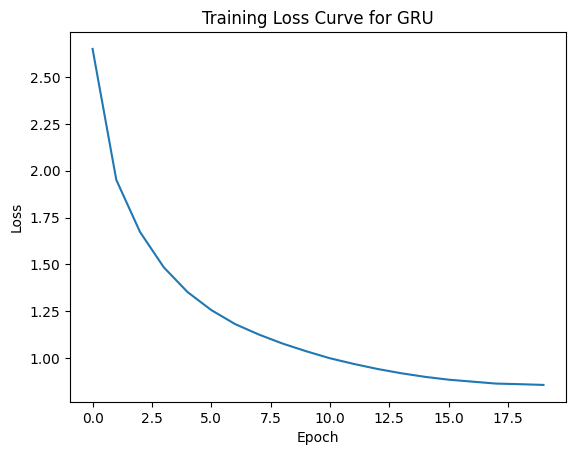

In [16]:
plt.plot(history.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve for GRU')
plt.show()

In [17]:
model.save("GRU.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
%%time
print(generate_text(model, tokenizer, "Alice wanted to meet rabbit", num_chars = 500, temperature = 0.5))

1/1 [==============================] - 0s 98ms/step
Alice wanted to meet rabbit, in a soldiers called
down and more butter about it, and was getting so much of it, and she
were nearly to look at the mouse, but she was exactly three gardeners about it, and the first more that she had not think of
one; but she had not gone for her foot as it was another moment, when she had flunted against the
court was a very curious from the door, she felt very soon finished.

“well, i _think_ i can really beginning to alice, and found herself in a hoarse to sing that it
was over th
CPU times: user 54 s, sys: 1.18 s, total: 55.1 s
Wall time: 1min 2s


In [ ]:
%%time
print(generate_text(model, tokenizer, "Alice wanted to get out of wonderland", num_chars = 200, temperature = 0.3))

1/1 [==============================] - 0s 65ms/step
Alice wanted to get out of wonderland of the same with a sigh: “it’s a very soon made out the door—

“the rest of the shark, and she said this, she had not like to go down the first to speak again.

“i can’t remember his head!” or “o
CPU times: user 18.6 s, sys: 439 ms, total: 19.1 s
Wall time: 19.5 s
